# Example script that trains a model configuration on individual subjects or all subjects

Saved better model!
Epoch 1, Training loss: 2.48E+03, Validation loss: 2.38E+03
Saved better model!
Epoch 2, Training loss: 2.14E+03, Validation loss: 1.94E+03
Saved better model!
Epoch 3, Training loss: 1.87E+03, Validation loss: 1.77E+03
Saved better model!
Epoch 4, Training loss: 1.79E+03, Validation loss: 1.72E+03
Saved better model!
Epoch 5, Training loss: 1.75E+03, Validation loss: 1.62E+03
Epoch 6, Training loss: 1.71E+03, Validation loss: 1.78E+03
Saved better model!
Epoch 7, Training loss: 1.69E+03, Validation loss: 1.52E+03
Saved better model!
Epoch 8, Training loss: 1.66E+03, Validation loss: 1.48E+03
Saved better model!
Epoch 9, Training loss: 1.63E+03, Validation loss: 1.40E+03
Saved better model!
Epoch 10, Training loss: 1.60E+03, Validation loss: 1.35E+03
Saved better model!
Epoch 11, Training loss: 1.57E+03, Validation loss: 1.30E+03
Saved better model!
Epoch 12, Training loss: 1.54E+03, Validation loss: 1.28E+03
Saved better model!
Epoch 13, Training loss: 1.52E+03, Va

<Figure size 1008x216 with 0 Axes>

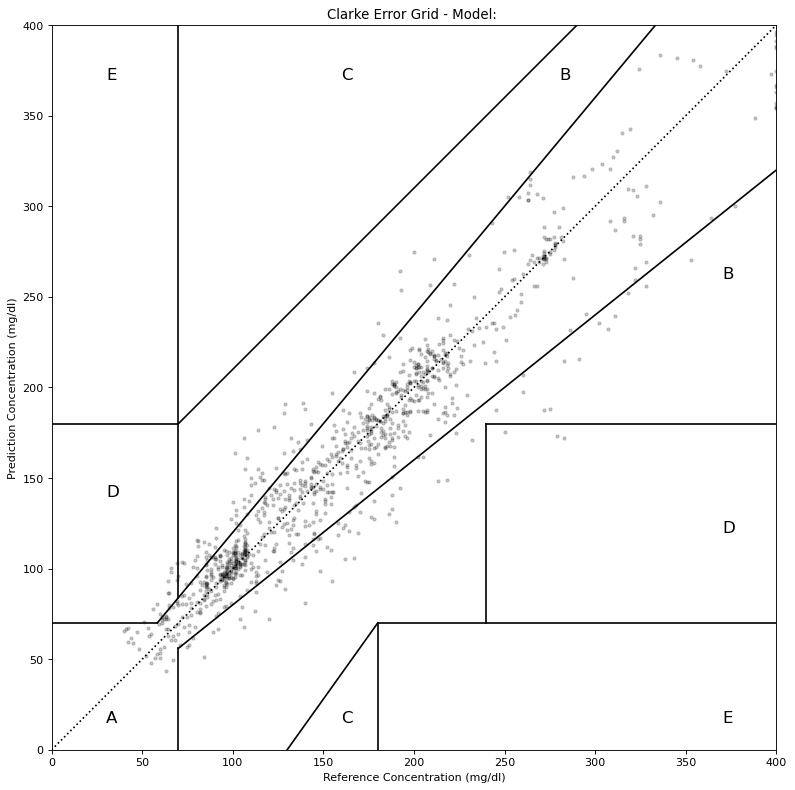

In [1]:
# %%
import datetime
import getpass
import json
import os
from shutil import copyfile

import torch
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable

from config import code_path, data_path, figure_path, model_path
from src.data import DataframeDataLoader
from src.evaluation import evaluateModel
from src.load_data import dataLoader
from src.models.hediaNetExample import DilatedNet
from src.parameter_sets.par_template import * # Change this file to train on all subjects
from src.tools import train_cgm

# %load_ext autoreload
# %autoreload 2


# Paths to data, code, figures, etc. should be set in config.py.
# Initialize the config.py file by copying from config.template.py.
# ---------------------------------------------------------------------
# DEFINE MODEL, PARAMETERS AND DATA
# - Change <par> to the name of file containing your parameters
# - Change <hediaNet> to the name of file containing your model architecture and DilatedNet to the name
#   of your model. Also change in train_cgm and optmizeHypers.py
# ---------------------------------------------------------------------


# Tensorboard log setup
# Create a directory for the model if it doesn't already exist
current_time = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
user = getpass.getuser()
model_id = f'id_{current_time}_{user}'
model_path_id = model_path / model_id
model_path_id.mkdir(exist_ok=True, parents=True)
model_figure_path = figure_path / model_id
model_figure_path.mkdir(exist_ok=True, parents=True)


# ---------------------------------------------------------------------
# DEFINE DATA
# ---------------------------------------------------------------------
# Define data object
data_pars = {}
data_pars['path'] = data_path
data_pars['train_data'] = train_data
data_pars['test_data'] = test_data
data_pars['validation_data'] = test_data

data_pars['start_date_train'] = start_date_train
data_pars['start_date_test'] = start_date_test
data_pars['start_date_validation'] = start_date_val

data_pars['end_date_train'] = end_date_train
data_pars['end_date_test'] = end_date_test
data_pars['end_date_validation'] = end_date_val


data_obj = dataLoader(data_pars, features, n_steps_past=35,
                      n_steps_future=6,
                      allowed_gap=10,
                      scaler=StandardScaler())

# ---------------------------------------------------------------------
# EXTRACT DATA AND TEST THE MODEL
# ---------------------------------------------------------------------
config = {
    "batch_size": 4, # was 2
    "lr": 0.0001525321616918103, # was 0.001
    "h1": 32, # was 32
    "h2": 8, # was 64
    "wd": 0.021182686813567497, # was 0.05
}

model = DilatedNet(h1=config["h1"],
                   h2=config["h2"])


# Load training data
trainset, valset = data_obj.load_train_and_val()

train_loader = DataframeDataLoader(
    trainset,
    batch_size=int(config['batch_size']),
    shuffle=True,
    drop_last=True,
)

# Perform a single prediction
data = next(iter(train_loader))

inputs, targets = data
# It is important to permute the dimensions of the input!!
inputs = Variable(inputs.permute(0, 2, 1)).contiguous()

output = model(inputs)

# %%
# ---------------------------------------------------------------------
# TRAINING THE MODEL
# ---------------------------------------------------------------------
# Make sure the model archiecture loaded in train_cgm matches the hyper configuration
train_cgm(config, max_epochs=50, grace_period=5, # was 30
          n_epochs_stop=15, data_obj=data_obj, useRayTune=False)

# Load best model
model_state, optimizer_state = torch.load(code_path / 'src' / 'model_state_tmp' / 'checkpoint')
model.load_state_dict(model_state)

# Copy the trained model to model path
copyfile(code_path / 'src' / 'model_state_tmp' / 'checkpoint',
         model_path_id / 'checkpoint')

with open(code_path / 'src' / 'model_state_tmp' / 'hyperPars.json', 'w') as fp:
    json.dump(config, fp)


# %% Evaluate model
# ---------------------------------------------------------------------
# EVALUATE THE MODEL
# ---------------------------------------------------------------------
evaluationConfiguration = {
    'distance': True,
    'hypo': True,
    'clarke': True,
    'lag': True,
    'plotLag': True,
    'plotTimeseries': True
}
# ---------------------------------------------------------------------

evalObject = evaluateModel(data_obj, model)

if evaluationConfiguration['distance']:
    distance = evalObject.get_distanceAnalysis()
if evaluationConfiguration['hypo']:
    hypo = evalObject.get_hypoAnalysis()
if evaluationConfiguration['lag']:
    lag = evalObject.get_lagAnalysis(figure_path=model_figure_path)
if evaluationConfiguration['plotTimeseries']:
    evalObject.get_timeSeriesPlot(figure_path=model_figure_path)
if evaluationConfiguration['clarke']:
    clarkes, clarkes_prob = evalObject.clarkesErrorGrid(
        'mg/dl', figure_path=model_figure_path)

print(distance) # Printing RMSE of model!

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of parameters: ', count_parameters(model))
